AE with one Interaction layers

In [1]:
import numpy as np
import itertools
import os, sys
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
from progressBar import ProgressBar

In [16]:
dnd = []

## Get the dataset

In [4]:
from torch.utils import data

In [24]:
class Dataset(data.Dataset):
    def __init__(self, names = 'SM', 
                 template='../data/20190625_10part_PtOrder/{}_lepFilter_13TeV.npy'):
        if names == 'SM':
            self.SM_names = ['Wlnu', 'qcd', 'ttbar', 'Zll']
            names = self.SM_names
        self.names = names
        
        self.feature_names = ['Pt', 'eta', 'phi', 'charge', 'pId']
        
        for i, n in enumerate(names):
            ins = np.load(template.format(n)).astype(np.float32)
            lbs = i*np.ones(ins.shape[0]).astype(np.int8)
            
            print(n, ':', str(ins.shape[0]))
            
            if i == 0:
                self.inputs = ins
                self.labels = lbs
            else:
                self.inputs = np.concatenate((self.inputs, ins))
                self.labels = np.concatenate((self.labels, lbs))
    
    def __len__(self):
        return self.inputs.shape[0]
    
    def __getitem__(self, idx):
        return self.inputs[idx], self.inputs[idx]

In [25]:
dataset = {}
# Use to do validation split
# torch.utils.data.random_split(dataset, lengths)
dataset['train'] = Dataset(['Zll'])

Zll : 100000


## Define the model

In [7]:
class AEGraphNet(nn.Module):
    def __init__(self, N_nodes, N_features, dim_hidden, De, Do, dim_latent, verbose = False):
        super(AEGraphNet, self).__init__()
        self.verbose = verbose
        
        self.p = N_features
        self.No = N_nodes
        self.De = De
        self.Do = Do
        self.Nk = dim_latent
        
        # Define the T/R matrixes
        self.Rr, self.Rs = self.buildEdgesMatrixes() 
        # As soon dim are fixed and connections are the same this is enough
        
        self.encoder_modules = nn.ModuleDict({
            'fr': self.build_dense(dim_in=2*self.p,
                                   dim_out=self.De,
                                   dim_hidden=dim_hidden),
            'fo': self.build_dense(dim_in=self.p + self.De,
                                   dim_out=self.Do,
                                   dim_hidden=dim_hidden),
            'PhiC': self.build_Phi(dim_in=self.Do,
                                    dim_out=self.Nk)
        })
        
        
        self.decoder_modules = nn.ModuleDict({
            'PhiU': self.build_Phi(dim_in=self.Nk,
                                   dim_out=self.No*self.Do),
            'fr': self.build_dense(dim_in=2*self.Do,
                                   dim_out=self.De,
                                   dim_hidden=dim_hidden),
            'fo': self.build_dense(dim_in=self.Do + self.De,
                                   dim_out=self.p,
                                   dim_hidden=dim_hidden)
        })
        
        
        self.onGPU = False
             
    def buildEdgesMatrixes(self):
        ### Assume fully connected graph
        Ne = self.No * (self.No - 1)
        self.Ne = Ne
        Rr = torch.zeros(self.No, Ne)
        Rs = torch.zeros(self.No, Ne)
        receiver_sender_list = [i for i in itertools.product(range(self.No), range(self.No)) if i[0]!=i[1]]
        for i, (r, s) in enumerate(receiver_sender_list):
            Rr[r, i] = 1
            Rs[s, i] = 1
        return Rr, Rs
          
    def build_dense(self, dim_in, dim_out, dim_hidden):
        net = nn.Sequential(
                            nn.Linear(dim_in, dim_hidden),
                            nn.ReLU(),
                            nn.Linear(dim_hidden, int(dim_hidden/2)),
                            nn.ReLU(),
                            nn.Linear(int(dim_hidden/2), dim_out),
                            nn.ReLU(),
                          )
        return net

    def build_Phi(self, dim_in, dim_out):
        Phi = nn.Sequential(
                              nn.Linear(dim_in, int(0.5*(dim_out + dim_in))),
                              nn.ReLU(),
                              nn.Linear(int(0.5*(dim_out + dim_in)), dim_out),
                              nn.ReLU()
                            )
        return Phi
         
    def INlayer(self, x, modules):
#         print(x.shape)
        local_p = x.shape[2]
        x = torch.transpose(x, 1, 2).contiguous()
#         print(x.shape)
#         print(self.Rr.shape)
        Orr = torch.matmul(x, self.Rr)
#         print(Orr.shape)
        Ors = torch.matmul(x, self.Rs)
        B = torch.cat([Orr, Ors], dim=1)
        
        ### First MLP ###
#         print(B.shape)
#         print(modules['fr'])
#         print(B.view(-1, 2 * local_p).shape)
        E = modules['fr'](B.view(-1, 2 * local_p))
        del B
        
        E = E.view(-1, self.Ne, self.De)
        E = torch.transpose(E, 1, 2).contiguous()
        Ebar = torch.matmul(E, torch.transpose(self.Rr, 0, 1).contiguous())
        del E
        
        C = torch.cat([x, Ebar], 1)
        del Ebar
        
        C = torch.transpose(C, 1, 2).contiguous()
        O = modules['fo'](C.view(-1, local_p + self.De))
        del C
        local_Do = modules['fo'][-2].out_features
        O = torch.relu(O.view(-1, self.No, local_Do))
        return O
        
    def encode(self, x):
        O = self.INlayer(x, self.encoder_modules)
        
        O = torch.sum(O, 1)
        z = self.encoder_modules['PhiC'](O)
        return z
    
    def decode(self, z):
        O = self.decoder_modules['PhiU'](z).view(-1, self.No, self.Do)
        x_raw = self.INlayer(O, self.decoder_modules)
        
        return x_raw
        
    
    def forward(self, x):
        z = self.encode(x)
        x_prime = self.decode(z)
        return x_prime
    
    def initWeights(self):
        def weights_init(M):
            if hasattr(M, 'weight'):
                nn.init.xavier_normal_(M.weight.data)
        
        self.apply(weights_init)
    
    def useGPU(self):
        if torch.cuda.is_available():
            print('Current device: {} ({} available)'.format(torch.cuda.current_device(), 
                                                             torch.cuda.device_count()))
            
            for o in self.__dict__.values():
                if o.__class__ == torch.Tensor:
                    o.cuda()
            
            self.onGPU = True
        else: 
            print('GPU not available')

In [8]:
model = AEGraphNet(
                   N_nodes=dataset['train'].inputs.shape[1],
                   N_features=dataset['train'].inputs.shape[2],
                   dim_hidden=15,
                   De=4,
                   Do=7,
                   dim_latent=5
                  )

print(model)
trainablePars = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('\nTrainable parameters:', trainablePars)

model.initWeights()

AEGraphNet(
  (encoder_modules): ModuleDict(
    (PhiC): Sequential(
      (0): Linear(in_features=7, out_features=6, bias=True)
      (1): ReLU()
      (2): Linear(in_features=6, out_features=5, bias=True)
      (3): ReLU()
    )
    (fo): Sequential(
      (0): Linear(in_features=9, out_features=15, bias=True)
      (1): ReLU()
      (2): Linear(in_features=15, out_features=7, bias=True)
      (3): ReLU()
      (4): Linear(in_features=7, out_features=7, bias=True)
      (5): ReLU()
    )
    (fr): Sequential(
      (0): Linear(in_features=10, out_features=15, bias=True)
      (1): ReLU()
      (2): Linear(in_features=15, out_features=7, bias=True)
      (3): ReLU()
      (4): Linear(in_features=7, out_features=4, bias=True)
      (5): ReLU()
    )
  )
  (decoder_modules): ModuleDict(
    (PhiU): Sequential(
      (0): Linear(in_features=5, out_features=37, bias=True)
      (1): ReLU()
      (2): Linear(in_features=37, out_features=70, bias=True)
      (3): ReLU()
    )
    (fo): Sequ

## Loss

In [9]:
criterion = nn.L1Loss()

## Training

In [10]:
training_params = {'batch_size': 128,
                   'shuffle': True,
                   'num_workers': 0
                  }

max_epochs = 50

In [11]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, 
                              mode='min',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              threshold=1e-4,
                              cooldown=2
                             )

In [12]:
optimizer.zero_grad()
data_train_iter = data.DataLoader(dataset['train'], **training_params)

train_loss = []
for epoch in range(1, max_epochs+1):
    batch_loss = []
    pb = ProgressBar(len(data_train_iter), percentPrecision=5, headLabel='Ep {} '.format(epoch))
    for local_x, _ in data_train_iter:
        if model.onGPU:
            local_x = local_x.cuda()
        
        x_prime = model(local_x)
        loss = criterion(local_x.view(-1, model.No*model.p), x_prime.view(-1, model.No*model.p))
        batch_loss.append(loss.item())
        
        tail_label = 'Loss: {:2.2e}'.format(loss.item())
        if len(train_loss) > 0:
            tail_label += ' ({:2.2e})'.format(loss.item() - train_loss[-1][-1])
        pb.show(len(batch_loss)-1, tail_label=tail_label)
        loss.backward()
        optimizer.step()
        
    scheduler.step(batch_loss[-1])
    printout = 'Loss: {:2.2e}'.format(batch_loss[-1])
    if len(train_loss) > 0:
        printout += ' - Delta: {:2.2e}'.format(batch_loss[-1] - train_loss[-1][-1])
    if len(train_loss) > 1:
        d2L_de2 = batch_loss[-1] - 2*train_loss[-1][-1] + train_loss[-2][-1]
        printout +=' - Trend: {:2.2e}'.format(d2L_de2)
    print(printout+'\n')
    train_loss.append(batch_loss)
    
train_loss = np.array(train_loss)

Ep 1 [####################]  100% - Tot. time: 10.8 s           
Loss: 2.66e+00

Ep 2 [####################]  100% - Tot. time: 9.8 s                        
Loss: 2.28e+00 - Delta: -3.75e-01

Ep 3 [####################]  100% - Tot. time: 9.7 s                        
Loss: 2.32e+00 - Delta: 3.45e-02 - Trend: 4.09e-01

Ep 4 [####################]  100% - Tot. time: 10.4 s                       
Loss: 2.39e+00 - Delta: 6.71e-02 - Trend: 3.26e-02

Ep 5 [####################]  100% - Tot. time: 9.8 s                        
Loss: 2.35e+00 - Delta: -3.46e-02 - Trend: -1.02e-01

Ep 6 [####################]  100% - Tot. time: 11.1 s                       
Loss: 2.20e+00 - Delta: -1.54e-01 - Trend: -1.20e-01

Ep 7 [####################]  100% - Tot. time: 10.6 s                       
Loss: 2.33e+00 - Delta: 1.35e-01 - Trend: 2.89e-01

Ep 8 [####################]  100% - Tot. time: 14.4 s                       
Loss: 2.35e+00 - Delta: 1.80e-02 - Trend: -1.17e-01

Ep 9 [####################] 

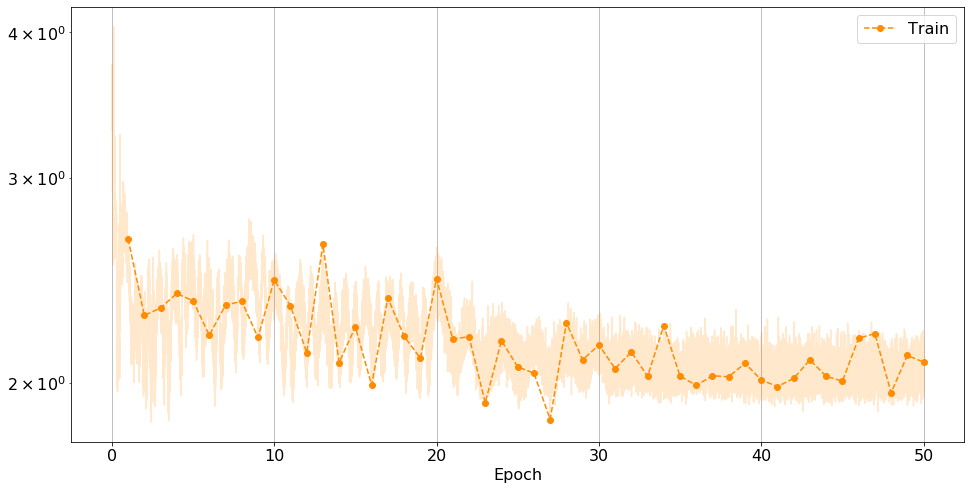

In [13]:
matplotlib.rcParams.update({'font.size': 16})

f = plt.figure(figsize=(16,8))

train_loss_flat = train_loss.flatten()
x = np.arange(1, train_loss_flat.shape[0]+1) * float(train_loss.shape[0])/train_loss_flat.shape[0]
plt.plot(x, train_loss_flat, '-', alpha=0.2, color='darkorange')

x = np.arange(1, train_loss.shape[0]+1)
plt.plot(x, train_loss[:,-1], 'o--', label='Train', color='darkorange')

plt.xlabel('Epoch')
plt.grid()
plt.legend(loc='best')
plt.yscale('log')
# f.savefig('plots/TrainingHistory_VAE_all-in-one_v'+VAEversion+'.png')

# f = open('TrainingHistory_VAE_all-in-one_v'+VAEversion+'.pkl', 'w')
# pickle.dump(fit_report.history, f, pickle.HIGHEST_PROTOCOL)
# f.close()

# Convergence check

In [17]:
x = dataset['train'].inputs
x_prime = model(torch.Tensor(dataset['train'].inputs)).cpu().detach().numpy()

### Output features

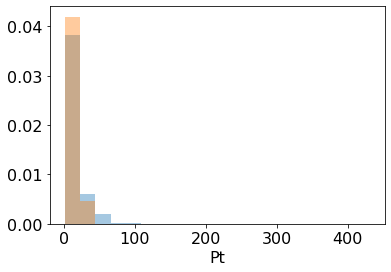

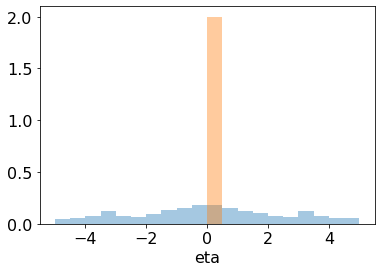

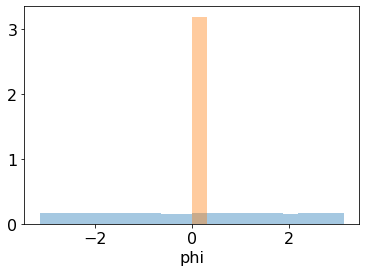

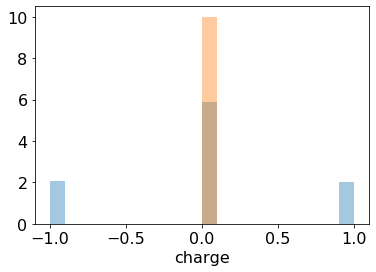

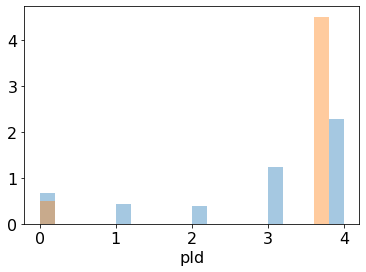

In [28]:
for i in range(x_prime.shape[2]):
    x_aux = x[:,:,i].flatten()
    xp_aux = x_prime[:,:,i].flatten()
    f = plt.figure(i)
    r = (min(np.min(x_aux), np.min(xp_aux)), max(np.max(x_aux), np.max(xp_aux)))
    plt.hist(x_aux, bins=20, range=r, alpha=0.4, density=True)
    plt.hist(xp_aux, bins=20, range=r, alpha=0.4, density=True)
    plt.xlabel(dataset['train'].feature_names[i])
    dnd.append(f)